In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stripROtools
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import crystalball

from stripROtools import colors
from stripROtools import GetTransErrs
from stripROtools import gaus2
from stripROtools import Mismeasurment_vs_z
from stripROtools import random_three_vector
from stripROtools import plot_track

In [19]:
# Solid angle range in theta [degrees]
theta_min = 15
theta_max = 30


In [20]:
# dataframe with time offset info
T_off = pd.read_pickle("./data/time_offset.pk")
T_off


,Name,Mu,Mu_err,Sigma,Sigma_err
0,UH DLC a,-6.684141,0.031719,16.382493,0.024764
1,UH DLC b,-5.208232,0.034228,16.305925,0.026783
2,UH DLC c,6.752723,0.038583,14.113659,0.031446
3,UH DLC d,6.852294,0.058807,14.800689,0.048234
4,UH NoDLC a,5.703480,0.075588,19.574833,0.061573
5,UH NoDLC b,5.473110,0.114114,19.799337,0.092169
6,UH NoDLC c,25.241775,0.189180,18.082547,0.159142
7,UH NoDLC d,20.674842,0.698955,17.886667,0.626167
8,UoS,-11.400385,0.026963,15.290716,0.021079


# Read dE/dx data from SRIM

In [21]:
# Load dEdx data simulated with SRIM
dEdx_data = np.loadtxt("./data/srim_po210_heco2.txt",skiprows=4)

dEdx_data = dEdx_data.T

# convert from angstrom to cm
dEdx_data[0] = dEdx_data[0]*1e-8

#dEdx resolution as seen in dEdx_data[0] 
delta_x = 0.1

# convert to eV/cm
dEdx_data[1] = dEdx_data[1]/1e-8
dEdx_data[2] = dEdx_data[2]/1e-8

dEdx = dEdx_data[1] + dEdx_data[2]




# Simulate Po210 alpha tracks

In [22]:
# The paramters, in order, are:
# number of simulations
# minimum angle to vertical [degrees] - this is based  on requiring a min. of 5 hits
# maximum angle to vertical [degrees]
# drfit length [cm]
# Apply diffusion T/F
# Transverse diffusion coefficent from Magboltz [cm/sqrt(cm)]
# W-value as obtained using degrad

def sim_p210(n_sims = 500, theta_min = theta_min, theta_max = theta_max, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2):

    tracks = pd.DataFrame(columns = ['direction', 'start', 'track'])

    for i in range(n_sims):

        # draw a random direction within specified solid angle (pointing down towards the readout plane)
        v = random_three_vector(theta_min,theta_max)

        # Maximumm track length of alpha track
        L_max = -DL/v[2]

        # Length segments we will distribute charge on, 0.1 is the resolution of length of the SRIM simulation
        L_segments = np.arange(0,L_max,0.1)

        # Edges of the length segments we will distribute charge on (all edges are listed)
        L_edges = np.append(L_segments,L_max)

        # Energy deposited in each segment given dEdx (energy in each bin is listed)
        E_segments = dEdx[0:len(L_segments)]*np.diff(L_edges)

        # Compute corresponding number of ionizaed eletrons using energy deposited per segment divided by W-value
        Ne_segments = np.round(E_segments/W).astype("int")

        #find left and right edges for each bin
        Left_edges = L_segments[0:-1]
        Right_edges = L_segments[1:]

        track = np.empty((0,3))

        for N,left_edge,right_edge in zip(Ne_segments,Left_edges,Right_edges):

            Ts = np.random.uniform(low=left_edge,high=right_edge,size=N)

            if Diff == False:

                x_vals = Ts*v[0]
                y_vals = Ts*v[1]
                z_vals = DL + Ts*v[2]

                Track_segment = np.array([x_vals,y_vals,z_vals]).T

                track = np.append(track,Track_segment,axis=0)
            
            elif Diff == True:

                z_vals = DL + Ts*v[2]

                x_vals = Ts*v[0] + DTrans*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))
                y_vals = Ts*v[1] + DTrans*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))
                z_vals = z_vals + DLong*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))

                Track_segment = np.array([x_vals,y_vals,z_vals]).T

                track = np.append(track,Track_segment,axis=0)

        x_rand = np.random.uniform()-0.5
        y_rand = np.random.uniform()-0.5

        track[:,0] = track[:,0]+x_rand # randomize x position (1 cm random uniform dist)
        track[:,1] = track[:,1]+y_rand # randomize x position (1 cm random uniform dist)

        tracks = tracks.append({'direction' : v, 'start' : np.array([x_rand,y_rand,DL]), 'track' : track }, ignore_index = True)

    return tracks




In [23]:
# Example of track simulation
tracks = sim_p210(n_sims = 100)
tracks.head()

,direction,start,track
0,"[0.09877589869275157, 0.2616118171498473, -0.9...","[-0.17503583372242637, 0.467007590529836, 1.2]","[[-0.19136652300489937, 0.47800752047227946, 1..."
1,"[-0.009738990507685995, -0.43614787334018645, ...","[-0.3557399965338959, -0.33235400996277065, 1.2]","[[-0.3550165231106937, -0.3516990010272384, 1...."
2,"[0.02341429577927457, 0.3912353936273693, -0.9...","[0.2968078262021224, 0.49234392454200826, 1.2]","[[0.2894595362425925, 0.5051901521887625, 1.19..."
3,"[0.28491594946198034, -0.1373115823369903, -0....","[-0.06349953706411804, -0.20170002761237082, 1.2]","[[-0.045163711596274414, -0.2038877270683944, ..."
4,"[-0.3497638513129357, 0.31962648180550746, -0....","[0.16677282861302656, -0.31768895719981116, 1.2]","[[0.13101926663569163, -0.27897795047495966, 1..."


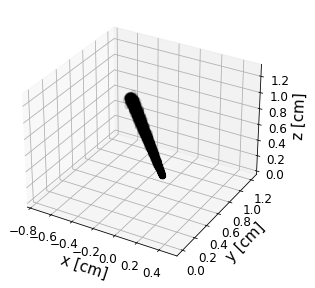

In [24]:
# Plot a Track
index = 0
track = tracks.iloc[index]["track"]
plot_track(track)

# Simulate readout


In [25]:
# the parameters, in order, are:
# peaking time [ns]
# digitization time [ns] 
# pitch of the x strips [um]
# pitch of the y strips [um]
# Threshold of x strips [No. electrons]
# Threshold of y strips [No. electrons]
# Charge sharing [lower strips / upper strips]
# Gain - extrapolating from PHA curve
# drift speed cm/ns
# Include charge integration effect.
# z resolution in cm, must be specified if Charge_integration = False
# Electronic gain in x [mV/fC]
# Electronic gain in y [mV/fC]

def sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = 200, pitch_y = 200,thres_x = 82/9.0*6241.5, thres_y =  82/4.5*6241.5, CS = 0.62, Gain = 505.7, v_drift = 0.0008, Charge_integration = True, pitch_z = 0.02, G_x = 9.0, G_y = 4.5):

    #convert pitch to cm
    pitch_x = pitch_x * 1e-4
    pitch_y = pitch_y * 1e-4
    
    # Readout is 10 cm x 10 cm
    x_bins = np.arange(-5,5,pitch_x)
    y_bins = np.arange(-5,5,pitch_y)

    # Find strip edges in x and y
    Left_edges_x = x_bins[0:-1]
    Right_edges_x = x_bins[1:]
    Left_edges_y = y_bins[0:-1]
    Right_edges_y = y_bins[1:]


    hits = pd.DataFrame(columns = ['strips_x', 'strips_y', 'times_x', 'times_y','electrons_x','electrons_y'])

    for index, row in tracks.iterrows():

        track = row.track

        x_positions = []
        x_charges = []
        x_times = []
        adcs0 = []
        strips0 = []

        for L_edge,R_edge in zip(Left_edges_x,Right_edges_x):

            # Bin track over specific strip in x
            T_track = track[(track[:,0]> L_edge) &  (track[:,0]< R_edge)]

            # If there is charge above this strip
            if len(T_track > 0):


                # If we are incuding the effects of finite charge integration time followed by digitization time
                if Charge_integration == True:

                    # Get time distribution of charge over this strip
                    time_dist = T_track[:,2]/v_drift

                    # Shift so that min is t = 0ns
                    min_time = np.min(time_dist)
                    time_dist= time_dist-min_time

                    # Keeping only the charge withing peaking time
                    time_dist = time_dist [time_dist < peaking_time]

                    # compute mean time for the hit
                    mean_time = np.mean(time_dist)+min_time

                    # obtain detected charge taking into account primary ionization, gain, and charge sharing
                    charge_detected = len(time_dist) *Gain * CS / (CS+1.0)

                    if charge_detected > thres_x:
                        
                        # obtain mean time for the hit
                        x_times += [mean_time]
                        # obtain position of the hit
                        x_positions += [ (L_edge+R_edge)/2.0 ]
                        # Position expressed consistently with exp digitized data
                        strips0 += [np.where(x_bins == L_edge)[0][0]]
                        # obtain detected charge taking into account primary ionization, gain, and charge sharing
                        x_charges += [ charge_detected ]
                        # Charge expressed consistently with exp digitized data
                        adcs0 += [min( charge_detected/6241.5*G_x, 1023.0 ) ]

                # Otherwise we bin the time axis according to the specified z resolution
                else:

                    # Bin in the z-dimension
                    z_bins = np.arange(0,1.2+pitch_z,pitch_z)
                    hist, bin_edges = np.histogram(T_track[:,2],bins=z_bins)
                    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

                    bin_centers = bin_centers[hist>0]
                    hist = hist[hist>0]

                    charge_detected = hist *Gain * CS / (CS+1.0)

                    # only keep hits above threshol
                    bin_centers = bin_centers[charge_detected>thres_x]
                    charge_detected = charge_detected [charge_detected>thres_x]


                    x_times += list(bin_centers/v_drift)
                    x_positions += list( np.ones(len(bin_centers)) * ((L_edge+R_edge)/2.0) )
                    x_charges += list(charge_detected)

        

        y_positions = []
        y_charges = []
        y_times = []
        adcs1 = []
        strips1 = []

        for L_edge,R_edge in zip(Left_edges_y,Right_edges_y):

            # Bin track over specific strip in x
            T_track = track[(track[:,1]> L_edge) &  (track[:,1]< R_edge)]

            # If there is charge above this strip
            if len(T_track > 0):

                # If we are incuding the effects of finite charge integration time followed by digitization time
                if Charge_integration == True:

                    # Get time distribution of charge over this strip
                    time_dist = T_track[:,2]/v_drift

                    # Shift so that min is t = 0ns
                    min_time = np.min(time_dist)
                    time_dist= time_dist-min_time

                    # Keeping only the charge withing peaking time
                    time_dist = time_dist [time_dist < peaking_time]

                    # compute mean time for the hit
                    mean_time = np.mean(time_dist)+min_time

                    # obtain detected charge taking into account primary ionization, gain, and charge sharing
                    charge_detected = len(time_dist) * Gain / (CS+1.0)

                    if charge_detected > thres_y:

                        # obtain mean time for the hit
                        y_times += [mean_time]
                        # obtain position of the hit
                        y_positions += [ (L_edge+R_edge)/2.0 ]
                        # Position expressed consistently with exp digitized data
                        strips1 += [np.where(y_bins == L_edge)[0][0]]
                        # obtain detected charge taking into account primary ionization, gain, and charge sharing
                        y_charges += [ charge_detected ]
                        # Charge expressed consistently with exp digitized data
                        adcs1 += [ min( charge_detected/6241.5*G_y, 1023.0 ) ] # The min imposes saturation of ADC scale

                # Otherwise we bin the time axis according to the specified z resolution
                else:

                    # Bin in the z-dimension
                    z_bins = np.arange(0,1.2+pitch_z,pitch_z)
                    hist, bin_edges = np.histogram(T_track[:,2],bins=z_bins)
                    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

                    bin_centers = bin_centers[hist>0]
                    hist = hist[hist>0]

                    charge_detected = hist * Gain / (CS+1.0)

                    # only keep hits above threshol
                    bin_centers = bin_centers[charge_detected>thres_y]
                    charge_detected = charge_detected [charge_detected>thres_y]


                    y_times += list(bin_centers/v_drift)
                    y_positions += list( np.ones(len(bin_centers)) * ((L_edge+R_edge)/2.0) )
                    y_charges += list(charge_detected)

        hits = hits.append({'strips_x' : np.array(x_positions), 'strips0' : np.array(strips0),  'strips_y' : np.array(y_positions), 'strips1' : np.array(strips1), 'times_x' : np.array(x_times), 'times0' : np.array(x_times), 'times_y' : np.array(y_times), 'times1' : np.array(y_times), 'electrons_x' :  np.array(x_charges), 'adcs0' :  np.array(adcs0), 'electrons_y' : np.array(y_charges), 'adcs1' :  np.array(adcs1) }, ignore_index = True)
        
    return hits


In [26]:
# Example of readout simulation
hits = sim_readout(tracks)
tracks = pd.concat([tracks,hits],axis=1)
tracks.head()


,direction,start,track,strips_x,strips_y,times_x,times_y,electrons_x,electrons_y,adcs0,adcs1,strips0,strips1,times0,times1
0,"[0.09877589869275157, 0.2616118171498473, -0.9...","[-0.17503583372242637, 0.467007590529836, 1.2]","[[-0.19136652300489937, 0.47800752047227946, 1...","[-0.11000000000010424, -0.09000000000010466, -...","[0.4699999999998834, 0.489999999999883, 0.5099...","[498.6185909727842, 333.7368702960937, 173.123...","[1431.0031401699216, 1341.5714807605734, 1245....","[60577.86543209876, 144186.93209876542, 347790...","[163572.09876543208, 179180.1234567901, 172624...","[87.35092347815251, 207.91194246397322, 501.50...","[117.93229903780251, 129.18538100705848, 124.4...","[244, 245, 246, 247]","[273, 274, 275, 276, 277, 278, 279, 280, 281, ...","[498.6185909727842, 333.7368702960937, 173.123...","[1431.0031401699216, 1341.5714807605734, 1245...."
1,"[-0.009738990507685995, -0.43614787334018645, ...","[-0.3557399965338959, -0.33235400996277065, 1.2]","[[-0.3550165231106937, -0.3516990010272384, 1....",[-0.3700000000000987],"[-0.8900000000000876, -0.870000000000088, -0.8...",[132.38904601536865],"[64.68573967785565, 113.80506420043125, 166.67...",[503589.79506172833],"[221009.6296296296, 222882.59259259258, 221946...",[726.1568782432996],"[159.34364068466445, 160.69401052097518, 160.0...",[231],"[205, 206, 207, 208, 209, 210, 211, 212, 213, ...",[132.38904601536865],"[64.68573967785565, 113.80506420043125, 166.67..."
2,"[0.02341429577927457, 0.3912353936273693, -0.9...","[0.2968078262021224, 0.49234392454200826, 1.2]","[[0.2894595362425925, 0.5051901521887625, 1.19...","[0.3099999999998868, 0.3299999999998864]","[0.5099999999998825, 0.5299999999998821, 0.549...","[179.9687236708379, 98.90067733559377]","[1429.5244058214196, 1375.4595184931784, 1326....","[78577.03950617283, 483074.60740740737]","[181989.56790123455, 206025.9259259259, 215078...","[113.30503173204445, 696.5747763625196]","[131.21093576152455, 148.54068199417873, 155.0...","[265, 266]","[275, 276, 277, 278, 279, 280, 281, 282, 283, ...","[179.9687236708379, 98.90067733559377]","[1429.5244058214196, 1375.4595184931784, 1326...."
3,"[0.28491594946198034, -0.1373115823369903, -0....","[-0.06349953706411804, -0.20170002761237082, 1.2]","[[-0.045163711596274414, -0.2038877270683944, ...","[-0.07000000000010509, -0.050000000000105516, ...","[-0.3700000000000987, -0.3500000000000991, -0....","[1462.8276623034985, 1378.13573147442, 1302.71...","[119.9022265641926, 194.78272358472384, 330.21...","[65996.97160493826, 70448.38024691357, 83802.6...","[253474.3209876543, 518186.4197530864, 323086....","[95.16506359760383, 101.58382155286743, 120.84...","[182.75005118071687, 373.6023213792981, 232.93...","[246, 247, 248, 249, 250, 251, 252, 253, 254, ...","[231, 232, 233, 234]","[1462.8276623034985, 1378.13573147442, 1302.71...","[119.9022265641926, 194.78272358472384, 330.21..."
4,"[-0.3497638513129357, 0.31962648180550746, -0....","[0.16677282861302656, -0.31768895719981116, 1.2]","[[0.13101926663569163, -0.27897795047495966, 1...","[-0.2900000000001004, -0.2700000000001008, -0....","[-0.3100000000001, -0.2900000000001004, -0.270...","[83.86396361841766, 126.47692204162672, 188.50...","[1441.58073838342, 1365.715906748731, 1308.119...","[72577.3148148148, 175540.33209876542, 173992....","[190105.74074074073, 170127.46913580247, 18948...","[104.65366231408046, 253.122324583656, 250.889...","[137.06253838553766, 122.65859346489002, 136.6...","[235, 236, 237, 238, 239, 240, 241, 242, 243, ...","[234, 235, 236, 237, 238, 239, 240, 241, 242, ...","[83.86396361841766, 126.47692204162672, 188.50...","[1441.58073838342, 1365.715906748731, 1308.119..."


# Perform 3D Reconstruction

[1139.91537616  992.51623577  857.6521752   720.33771862  584.52293052
  482.60930512  366.17684494  232.44465585  115.42110791    0.        ]


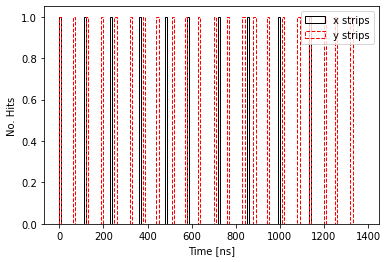

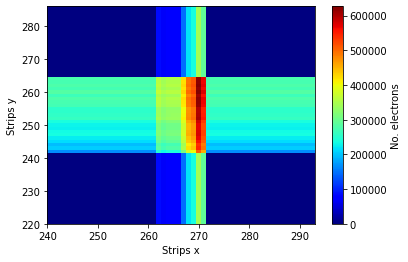

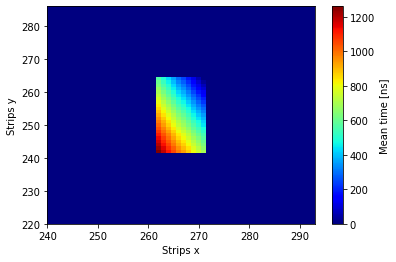

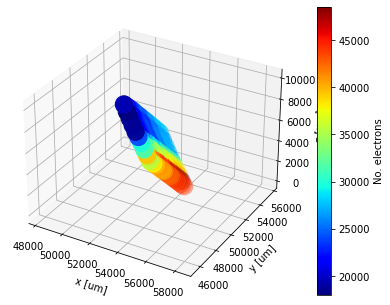

/Users/majdghrear/Lab/2DstripRO/stripROtools.py:663: RuntimeWarning: invalid value encountered in reciprocal
  abs_t_off = np.reciprocal(abs_t_off,where= abs_t_off!=0)


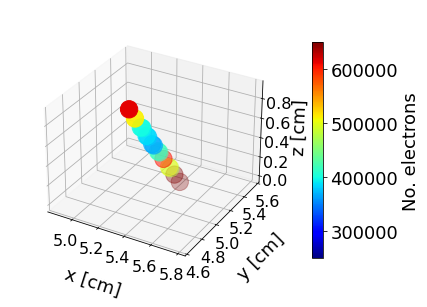

In [40]:
# 3D clustering paramters
mu = T_off.iloc[0]["Mu"]
sigma = T_off.iloc[0]["Sigma"]
n_sigma = 3

# Look at a single event after the cut
test_event = tracks.iloc[12]
# Make a TrackTools object for the event
dsp = stripROtools.TrackTools(event = test_event, Mult_factor = 1.0, gain_x=9, gain_y=4.5, v_drift=8.0)

# Plot 1D time display
dsp.TimeHistView( t_bin =10)

# Plot 2D displays of charge and time
dsp.Strip2DView(fullview = False)
dsp.Strip2DView_times(fullview = False)

# Plot 3D displays
dsp.Reconst3D_v0()
x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma,save_name = "sim_alpha")

# Assess point resolution

In [11]:
def get_PR(tracks, mu = -6.7, sigma = 16.4 , n_sigma = 3, G_x = 9.0, G_y = 4.5, n_strips_x = 500, n_strips_y=500, pitch_x=200, pitch_y=200, theta_min = theta_min, theta_max = theta_max):

    # Analyze point resolution
    all_z = np.array([])
    all_x_err_1 = np.array([])
    all_y_err_1 = np.array([])
    all_x_err_2 = np.array([])
    all_y_err_2 = np.array([])



    for index, row in tracks.iterrows():

        try:
            # Make a TrackTools object for the event
            dsp = stripROtools.TrackTools(event = row, Mult_factor = 1.0, gain_x=G_x, gain_y=G_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, v_drift=8.0, pitch_x=pitch_x, pitch_y=pitch_y) # Mult factor always 1 for sim
            
            # Remove delayed hits (as discussed in the slides)
            dsp.prune_track(T_L = 0, T_H=250)
            dsp.prune_track2(gap=2)

            x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma, plot = False)

            
            # Only consider tracks with 5 or more points 
            if len(x) > 5:

                # Get mismeasurements and absolute z values
                z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( x,y,z,c, charge_weighting = True)
                
                # Angle to vertical
                ang_z = np.arccos(v_PA[2])*57.2958

                if (ang_z>theta_min) and (ang_z<theta_max):
            
                    all_z = np.append(all_z,z_vals)
                    all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
                    all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
                    all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
                    all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
                

            
        except:
            pass

    # Switch to cm
    all_z = all_z*1E-4

    # Get mismeasurement versus abs. z using method 1
    abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2,plot=False)



    plt.figure()
    plt.errorbar(abs_z,np.abs(x_sigmas2),x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
    plt.errorbar(abs_z,np.abs(y_sigmas2),y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
    #plt.plot(abs_z_std,x_std,color=colors["blue"])
    #plt.plot(abs_z_std,y_std,color=colors["red"])
    plt.legend()
    plt.ylim((0,200))
    plt.xlabel("Abs. z [cm]")
    plt.ylabel("Effective Point Resolution [um]")
    plt.show()

    return np.abs(x_sigmas2), x_sigmas_err2, np.abs(y_sigmas2), y_sigmas_err2, abs_z

sigma x:  40.59408448890321 +/- 1.9506103473537308
sigma y:  47.714563120728506 +/- 2.836515515922026
sigma x:  40.23815561919707 +/- 2.2499376892371217
sigma y:  42.81732904203307 +/- 2.539706878880539
sigma x:  45.41244525877336 +/- 2.886189979962958
sigma y:  50.55258883505263 +/- 4.280711836234972
sigma x:  43.90957959889754 +/- 3.056897910557287
sigma y:  47.268802621002486 +/- 3.4633312442931823
sigma x:  50.373654275005705 +/- 3.484325844676981
sigma y:  51.82944651684758 +/- 3.5979639791257165
sigma x:  43.41624357813511 +/- 1.2256599851685746
sigma y:  45.47903807435634 +/- 1.191761270264968


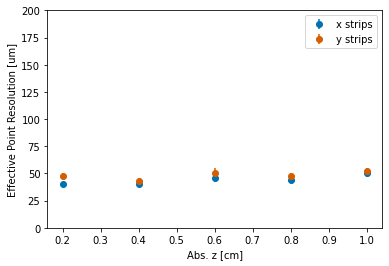

In [12]:
# Example point res calc
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR(tracks)

# Simulate Po210 in UH DLC Quadrant a



In [13]:
# Make dataframe to store all results

df_resolution = pd.DataFrame(columns = ['Name','x_res', 'x_res_err', 'y_res', 'y_res_err','abs_z'])

sigma x:  41.11546853463489 +/- 0.9201750826904775
sigma y:  40.325914735675795 +/- 0.8507159537741418
sigma x:  42.005214285034825 +/- 0.8964145049534142
sigma y:  40.68594121518411 +/- 0.9116217543339238
sigma x:  45.172699631873954 +/- 1.3322590035707598
sigma y:  43.4468918307269 +/- 1.0271154910387732
sigma x:  46.151537234554944 +/- 1.2611998250363543
sigma y:  45.01842015294471 +/- 1.1512380487836518
sigma x:  47.69731809371831 +/- 1.5284428400590415
sigma y:  49.43420254351481 +/- 1.5856570564443266
sigma x:  -42.2264123471394 +/- 0.44883473064068685
sigma y:  -41.812950980198394 +/- 0.42029266831660184


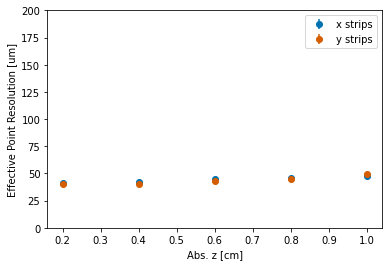

In [14]:
Charge_sharing = 0.41
Gain = 505.7
pitch_x = 200               # in um
pitch_y = 200               # in um
n_strips_x = 500
n_strips_y = 500
electronic_gain_x = 9.0     # in mV/fC
electronic_gain_y = 4.5     # in mV/fC

# 3D clustering paramters
mu = T_off.iloc[0]["Mu"]
sigma = T_off.iloc[0]["Sigma"]
n_sigma = 3

# simulatue tracks
tracks = sim_p210(n_sims = 500, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2)

# simulate readout
hits = sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = pitch_x, pitch_y = pitch_y,thres_x = 82/electronic_gain_x*6241.5, thres_y =  82/electronic_gain_y*6241.5, CS = Charge_sharing, Gain = Gain, v_drift = 0.0008, Charge_integration = True, pitch_z = 0.02, G_x = electronic_gain_x, G_y = electronic_gain_x)
tracks = pd.concat([tracks,hits],axis=1)


# Reconstruct and get point resolutions
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR(tracks, mu = mu, sigma = sigma , n_sigma = n_sigma, G_x = electronic_gain_x, G_y = electronic_gain_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, pitch_x=pitch_x, pitch_y=pitch_y, theta_min = theta_min, theta_max = theta_max)


df_resolution = df_resolution.append({'Name' : "UH_DLC_a", 'x_res' : x_res, 'x_res_err' : x_res_err, 'y_res' : y_res, 'y_res_err' :  y_res_err, 'abs_z' : abs_z }, ignore_index = True)



# Simulate Po210 in UH NoDLC Quadrant a

sigma x:  48.45428958991054 +/- 0.8447887242545079
sigma y:  46.45362472008663 +/- 0.7735217181687978
sigma x:  46.207126822868794 +/- 0.7911698409572208
sigma y:  46.024015446588514 +/- 0.793808523893467
sigma x:  46.584640423193235 +/- 0.8457099192731827
sigma y:  47.543184006480004 +/- 0.872862739794259
sigma x:  50.34047337587416 +/- 1.0824695922121201
sigma y:  52.766719210338785 +/- 1.2067233641906474
sigma x:  55.76473358664161 +/- 1.5232024527699362
sigma y:  56.986151229789336 +/- 1.4151354874728188
sigma x:  48.741326786991294 +/- 0.4371538985885715
sigma y:  48.89621649178879 +/- 0.4431412211218423


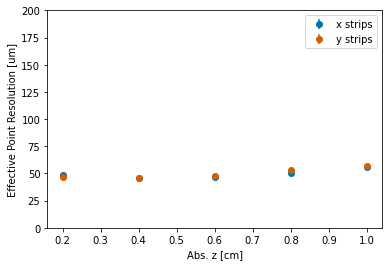

In [15]:
Charge_sharing = 0.62
Gain = 630.8
pitch_x = 200
pitch_y = 200
n_strips_x = 500
n_strips_y = 500
electronic_gain_x = 9.0
electronic_gain_y = 4.5


# 3D clustering paramters
mu = T_off.iloc[4]["Mu"]
sigma = T_off.iloc[4]["Sigma"]
n_sigma = 3

# simulatue tracks
tracks = sim_p210(n_sims = 500, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2)

# simulate readout
hits = sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = pitch_x, pitch_y = pitch_y,thres_x = 82/electronic_gain_x*6241.5, thres_y =  82/electronic_gain_y*6241.5, CS = Charge_sharing, Gain = Gain, v_drift = 0.0008, Charge_integration = True, pitch_z = 0.02, G_x = electronic_gain_x, G_y = electronic_gain_x)
tracks = pd.concat([tracks,hits],axis=1)

# Reconstruct and get point resolutions
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR(tracks, mu = mu, sigma = sigma , n_sigma = n_sigma, G_x = electronic_gain_x, G_y = electronic_gain_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, pitch_x=pitch_x, pitch_y=pitch_y, theta_min = theta_min, theta_max = theta_max )

df_resolution = df_resolution.append({'Name' : "UH_NoDLC_a", 'x_res' : x_res, 'x_res_err' : x_res_err, 'y_res' : y_res, 'y_res_err' :  y_res_err, 'abs_z' : abs_z }, ignore_index = True)



# Simulate Po210 in UoS

sigma x:  40.71875776099373 +/- 1.2876681182961534
sigma y:  39.79312496875324 +/- 1.2327089931415198
sigma x:  40.90418013900924 +/- 1.2648396845327274
sigma y:  38.18073355181505 +/- 1.0780988612807185
sigma x:  42.08413542235242 +/- 1.4238388483069042
sigma y:  41.52889245547212 +/- 1.3401544824850005
sigma x:  47.13685213280381 +/- 2.0682480363881792
sigma y:  42.513368228235414 +/- 1.4927652532676425
sigma x:  50.138852329258604 +/- 2.528460908162401
sigma y:  51.545454619744426 +/- 2.3345205443273795
sigma x:  43.26520330378031 +/- 0.728041882112542
sigma y:  40.601874734234684 +/- 0.5691627959573216


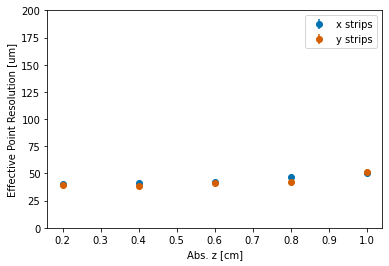

In [16]:
Charge_sharing = 0.13
Gain = 6490
pitch_x = 250
pitch_y = 250
n_strips_x = 358
n_strips_y = 358
electronic_gain_x 
electronic_gain_x= 1.0
electronic_gain_y = 1.0

# 3D clustering paramters
mu = T_off.iloc[8]["Mu"]
sigma = T_off.iloc[8]["Sigma"]
n_sigma = 3

# simulatue tracks
tracks = sim_p210(n_sims = 500, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2)

# simulate readout
hits = sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = pitch_x, pitch_y = pitch_y,thres_x = 82/electronic_gain_x*6241.5, thres_y =  82/electronic_gain_y*6241.5, CS = Charge_sharing, Gain = Gain, v_drift = 0.0008, Charge_integration = True, pitch_z = 0.02, G_x = electronic_gain_x, G_y = electronic_gain_x)
tracks = pd.concat([tracks,hits],axis=1)

# Reconstruct and get point resolutions
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR(tracks, mu = mu, sigma = sigma , n_sigma = n_sigma, G_x = electronic_gain_x, G_y = electronic_gain_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, pitch_x=pitch_x, pitch_y=pitch_y, theta_min = theta_min, theta_max = theta_max )

df_resolution = df_resolution.append({'Name' : "UoS", 'x_res' : x_res, 'x_res_err' : x_res_err, 'y_res' : y_res, 'y_res_err' :  y_res_err, 'abs_z' : abs_z }, ignore_index = True)



In [17]:
df_resolution.to_pickle("./data/resolution_sim.pk")
df_resolution

,Name,x_res,x_res_err,y_res,y_res_err,abs_z
0,UH_DLC_a,"[41.11546853463489, 42.005214285034825, 45.172...","[0.9201750826904775, 0.8964145049534142, 1.332...","[40.325914735675795, 40.68594121518411, 43.446...","[0.8507159537741418, 0.9116217543339238, 1.027...","[0.2, 0.4, 0.6, 0.8, 1.0]"
1,UH_NoDLC_a,"[48.45428958991054, 46.207126822868794, 46.584...","[0.8447887242545079, 0.7911698409572208, 0.845...","[46.45362472008663, 46.024015446588514, 47.543...","[0.7735217181687978, 0.793808523893467, 0.8728...","[0.2, 0.4, 0.6, 0.8, 1.0]"
2,UoS,"[40.71875776099373, 40.90418013900924, 42.0841...","[1.2876681182961534, 1.2648396845327274, 1.423...","[39.79312496875324, 38.18073355181505, 41.5288...","[1.2327089931415198, 1.0780988612807185, 1.340...","[0.2, 0.4, 0.6, 0.8, 1.0]"


# Appendix: Using charge-weighted std

In [18]:
# A function which bins missmeasurments in z and fits them to Gaussians, outputting the results
def Mismeasurment_vs_z_weighted( z_vals, x_mis , y_mis , charge, start = 0.1, stop = 1.0, step = 0.2):

    abs_z_std = []
    x_std_weighted = []
    y_std_weighted = []

    for z_low in np.arange(start,stop,step):

        #make data cut
        z_high = z_low + step
        data_cut = (z_vals > z_low) & (z_vals < z_high)

        x_temp = x_mis[data_cut]
        y_temp = y_mis[data_cut]
        charge_temp = charge[data_cut]
        #charge_temp = np.ones(len(x_temp))

        x_std_weighted += [np.sqrt(np.dot(x_temp*charge_temp,x_temp)/np.sum(charge_temp))]
        y_std_weighted += [np.sqrt(np.dot(y_temp*charge_temp,y_temp)/np.sum(charge_temp))]

        abs_z_std += [round( (z_low+z_high)/2.0 ,2)]


            


    return  abs_z_std, x_std_weighted, y_std_weighted



/Users/majdghrear/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in reciprocal


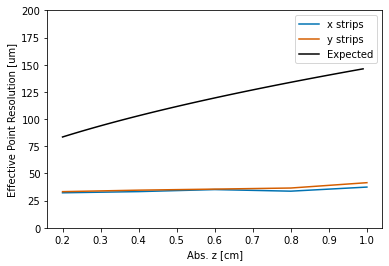

In [14]:
# Analyze point resolution
all_z = np.array([])
all_x_err_1 = np.array([])
all_y_err_1 = np.array([])
all_x_err_2 = np.array([])
all_y_err_2 = np.array([])

all_c = np.array([])



for index, row in tracks.iterrows():

    x,y,z,c = Reconst3D_v1(row.strips_x, row.strips_y, row.times_x, row.times_y, row.electrons_x, row.electrons_y,start=row.start,direction=row.direction, plot = False, save_name = None)

    # Only consider tracks with 5 or more points
    if len(x) > 5:
            
        # Get mismeasurements and absolute z values
        z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = GetTransErrs( x,y,z,c, charge_weighting = True)

        all_z = np.append(all_z,z_vals)
        all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
        all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
        all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
        all_y_err_2 = np.append(all_y_err_2,delta_ys_2)

        all_c = np.append(all_c,c)


# convert mismeaurments to cm 
all_x_err_1 = all_x_err_1 * 10000
all_y_err_1 = all_y_err_1 * 10000
all_x_err_2 = all_x_err_2 * 10000
all_y_err_2 = all_y_err_2 * 10000

# Git mismeasurement versus abs. z using method 1
abs_z_std, x_std, y_std = Mismeasurment_vs_z_weighted(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2, charge = all_c)

x_ref = np.arange(0.2,1.0,0.01)
y_ref = np.sqrt( (pitch_x*10000/np.sqrt(12))**2 + (np.sqrt(x_ref)*DTrans*10000)**2 )


plt.figure()
plt.plot(abs_z_std,x_std,color=colors["blue"],label="x strips")
plt.plot(abs_z_std,y_std,color=colors["red"],label="y strips")
plt.plot(x_ref,y_ref,color=colors["black"],label="Expected")
plt.legend()
plt.ylim((0,200))
plt.xlabel("Abs. z [cm]")
plt.ylabel("Effective Point Resolution [um]")
plt.show()


Using a charge-weighted standard deviation agrees with the non-charge weighted standard deviation